# Homework 2
## ME 326: Collaborative Robotics
### Stanford University

In [1]:
!pip install google-cloud-speech
!pip install google-cloud-vision
!pip install google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.5 MB/s eta 0:00:00


# Using Google APIs
For the group project, or just in general, rather than running a code locally on your system, it could be beneficial to have an external server run the code and provide the results to you. For this, APIs are very beneficial as they allow you to take advantage of complex code with only a single call over the internet. Google has a variety of models available through API calls including Gemini, Text to Speech, Vision Tools, Text Sentiment Analysis, etc., that could be very useful. This will provide a guide to setting up your account, enabling some APIs that could be useful for the group project, and providing some exposure on how to use them.

## Setting Up Google Cloud

1. Go to https://console.cloud.google.com/, this is the dashboard where you can control everything with respect to Google's APIs.
2. Sign in with your **personal** account. Stanford accounts will not work.
3. Set up your billing information with Google. Don't worry, we have credits that should cover all costs, but this is still required before they allow you to proceed.
4. Open the Project Selector. Look for the project dropdown near the top-left of the Cloud Console. It might say “Select a project” if you have none yet.
Click on the dropdown to expand the project selector.
5. Fill out the required information and create the project. Note you do not need to specify an organization or change anything from the defaults unless you specifically want to.
6. Once the project is created, you should see it in the top left of the screen.
7. The next step will be to enable any APIs that you would want. In the navigation menu on the left of the screen, go to "APIs and Services" and then "API Library".
8. Take a look at the provided APIs that Google offers. The APIs in the "Machine Learning" category are likely to be helpful for you. For each API that you are interested in, click on it and then click "Enable". This will enable it for the Project you created earlier.
9. Enable "Gemini API", "Cloud Speech-to-Text API", and the "Cloud Vision API". These will all be needed for this homework.

## Applying for Google Credits
1. Go to the [Student Coupon Retrieval Link](https://gcp.secure.force.com/GCPEDU?cid=7glw7pjVf3GwBIfyRm8cja%2BefkuriDHDSLm9Vq5NKDT9fDA2dCLJQ%2F5IJRl%2BwZwe/) and fill out your name and university email.
2. You will be asked to verify your email, and then the coupon will be delivered to your Stanford email.
3. Click the link to redeem the code, this will open up the Google Cloud console. Type in the coupon code provided in the email and redeem the coupon to your account.
4. You're done!

## Using the APIs
Now that the APIs are enabled, you'll want to use them. When you make a call via code, Google needs to know who is making the call. This is done one of two ways: an API key, or with the Gcloud App.

### Running Code on Personal Computer
The easiest way to run the APIs on your personal machine will be with the Google Cloud CLI
1. Install the [gcloud CLI](https://cloud.google.com/sdk/docs/install#windows) for the platform of your choice
2. In your terminal, run
```
gcloud init
```
3. Then in your local environment, for example in VSCode, run
```
gcloud auth login
```
This logs you in to the local environment and will allow you to use the APIs without explicitly setting keys.

This works for all APIs **EXCEPT** Gemini, Gemini requires an API key to be configured for it.

### Generating an API key for Gemini
1. For Gemini, an API key can be generated by going to "APIs & Services" in the navigation menu.
2. Click on "Credentials" then "Create Credentials" then "API Key"
3. This API key can then be used anywhere for Gemini. Be careful when sharing code with this key to avoid unwanted charges.

### Creating a JSON Key
For other situations, such as this homework or running code on other machines, a JSON key can be used to store your credentials that can easily be used anywhere.
1. Go to "IAM & Admin" from the navigation menu
2. Click on "Service Accounts" in the dropdown menu.
3. Create a service account. Fill out the details for the account.
4. Assign a role for the account. The easiest option would be "Owner". This will give it all the permissions that you would expect.
5. Click "Done". This will create the service account.
6. Click on the service account. This should take you to information about the service account.
7. Click "Keys" then "Add Key" and then "Create New Key".
8. Create a new JSON Key. It will be saved to your local device.
9. You can use this key by setting the path to it to the "GOOGLE_APPLICATION_CREDENTIALS" environment variable. See below for an example implementation.

This appears to work for all APIs **INCLUDING** Gemini



In [56]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cv2
import os
from google.colab import files
from PIL import Image
import wave
from google.cloud import speech_v1p1beta1 as speech
from google.colab import files
import google.generativeai as genai
#from google import  genai
import io
from google.cloud import vision
from PIL import Image as PILImage, ImageDraw, ImageFont
from IPython.display import display

# %matplotlib notebook #keep commented if using Google Colab, otherwise uncomment

## Readme:
This homework leverages an accompanying dataset. Please find it in canvas, and put it in the same level as this notebook. If you are using google colab there are a few ways to accomplish this [found on this page](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=jRQ5_yMcqJiV), mounting the drive locally, for example:
```
from google.colab import drive
drive.mount('/content/drive')
```

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After running the above, in the side panel on the left, open the folder, one symbol at the top allows you to refresh the folder, open your drive folder and navigate to where you've put the data folder, at the data folder, hit the options button and select "Copy Path" and paste that string below:

In [58]:
data_path = '/content/drive/MyDrive/Colab Notebooks/HW2_Data'
# data_path = 'data' #run this if you are running this locally and the data folder is at the same directory as the notebook

# Path to where you uploaded the API key:
json_key_path = "/content/drive/MyDrive/Colab Notebooks/HW2_Data/cs339rhw2-f89bd3711893.json" #this is an example, update with your path following instructions above

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_key_path


# Problem 1: Speech To Text

An important part of the group project will be to convert speech into text. The user will be communicating to the Locobot via speech. However, raw audio is hard for computers to interpret. To get around this, speech to text models have been developed to understand and transcribe speech. Google offers an API to do this that allows access to these models wth a single API call.

In this problem, you will fill in a function to call the Speech to Text API and have it return the transcribed text.

In [59]:
class SpeechTranscriber:
    def __init__(self, language_code='en-US', sample_rate=16000):
        """
        Initialize a SpeechTranscriber instance.

        :param language_code: The language code for transcription, e.g., 'en-US'.
        :param sample_rate: The sample rate (Hertz) of the audio file, default is 16000.
        """
        self.language_code = language_code
        self.sample_rate = sample_rate

        # Create the Speech client once
        self.client = speech.SpeechClient()

    def transcribe_audio(self, audio_content):
        """
        Uses Google Cloud Speech-to-Text to transcribe the given audio content (bytes).
        Returns the transcription as a string.

        :param audio_content: The raw bytes of the audio file to be transcribed.
        :return: A string of the combined transcription.
        """
        audio = speech.RecognitionAudio(content=audio_content)

        config = speech.RecognitionConfig(
            sample_rate_hertz=self.sample_rate,
            language_code=self.language_code,
            enable_automatic_punctuation=True,
            encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        )
        # Step 1: Perform the transcription
        response = self.client.recognize(config=config, audio=audio)

        # Step 2: Extract the transcription. Hint: we only want the first result
        if not response.results:
            return ""

        first_result = response.results[0]
        transcript = " ".join(
            alt.transcript.strip() for alt in first_result.alternatives if alt.transcript
        ).strip()

        #Step 3: Return the transcript
        return transcript


In [60]:
#Test your functions with the following code
tts = SpeechTranscriber()

#Transcribe the first audio file. You should see "I love collaborative robotics."
audio_content1 = data_path + "/API/recorded_audio1.wav"
with open(audio_content1, "rb") as audio_file:
    audio_content1 = audio_file.read()
transcription = tts.transcribe_audio(audio_content1)
print("Transcription:\n", transcription)

#Transcribe the second audio file
audio_content2 = data_path + "/API/recorded_audio2.wav"
with open(audio_content2, "rb") as audio_file:
    audio_content2 = audio_file.read()
transcription = tts.transcribe_audio(audio_content2)
print("Transcription:\n", transcription)

Transcription:
 I love collaborative robotics.
Transcription:
 These apis make speech to text so easy.


# Problem 2: LLMs / VLMs
LLMs (Large Language Models) and VLMs (Vision Language Models) are very useful in a large variety of situations. They generate text in response to a prompt consisting of text, an image or a combination of both. This makes them good for answering questions, sequential reasoning, pattern recognition, etc.

LLMs can also recognize critical elements in text and respond in a carefully formatted way that the user specifies. This can be done by promp engineering, where the LLM is given context as to what the user wants prior to responding to the text. In this question, you will work with Gemini and explore its capabilities with text and images.

You will first work to fill out the generate_content function so that Gemini will either respond to a query with and without a prompt influencing its response. Then you will fill out generate_from_image, so that Gemnini will respond to images as well.

In [80]:
class GeminiClass:
    def __init__(self, prompt=None):
        """
        Constructor for the GeminiClass.
        Initializes the generative model and sets a default prompt.

        Parameters:
        - prompt (optional): A string to set as the default prompt. Defaults to an empty string if not provided.
        """
        #Code to print available models.
        #for model in genai.list_models():
        #  print("MODEL:",model)

        self.gemini_model = genai.GenerativeModel("gemini-2.5-flash")

        if prompt:
            self.prompt = prompt
        else:
            self.prompt = ""

    def set_prompt(self, prompt):
        """
        Sets or updates the prompt for the GeminiClass.

        Parameters:
        - prompt: A string that will serve as the base prompt for content generation.
        """
        #Add code to set self.prompt to the provided prompt
        self.prompt = prompt if prompt is not None else ""

    def generate_content(self, text, usePrompt):
        """
        Generates content using the generative model.

        Parameters:
        - text: A string input to provide to the model for content generation.
        - usePrompt: A boolean indicating whether to prepend the class's prompt to the input text.

        Returns:
        - The generated content as a string.
        """
        #Add code to generate content from text. The usePrompt boolean should determine if the prompt is used or not.
        if usePrompt and self.prompt:
            full_input = f"{self.prompt}\n{text}"
        else:
            full_input = text

        response = self.gemini_model.generate_content(full_input)

        # Gemini responses usually store text in response.text
        return getattr(response, "text", str(response))

    def generate_from_image(self, image_bytes, textInput):
        """
        Generates content based on an image and optional text input.

        Parameters:
        - image_bytes: The binary data of the image.
        - textInput: A string input to accompany the image for content generation.

        Returns:
        - The generated content as a string.
        """
        # Add code that allows for the image and the text input to be passed to Gemini and return Gemini's response.
        #Hint: Gemini can accept multiple inputs in the form of a list.
        inputs = [image_bytes]
        if textInput is not None and str(textInput).strip():
            inputs.append(textInput)

        response = self.gemini_model.generate_content(inputs)
        return getattr(response, "text", str(response))

LLMs (Large Language Models) and VLMs (Vision-Language Models) are cutting-edge AI models that leverage deep learning to understand and generate human-like content. While they share fundamental principles, they differ in the modalities they process.

---

## How LLMs (Large Language Models) Work

LLMs are primarily designed to understand, generate, and process human language. Think of them as incredibly sophisticated text prediction engines.

**1. The Core Idea: Predicting the Next Token**
At their heart, LLMs are trained to predict the next word (or more accurately, "token," which can be a word, subword, or punctuation mark) in a sequence, given the preceding tokens. If you give it "The cat sat on the...", it tries to guess "mat," "couch," "rug," etc.

**2. Architecture: The Transformer**
Almost all modern LLMs are built upon the **Transformer architecture**, introduced by Google in 2017. The Transformer is revolutionary because it can process all parts of an input sequence simultaneo

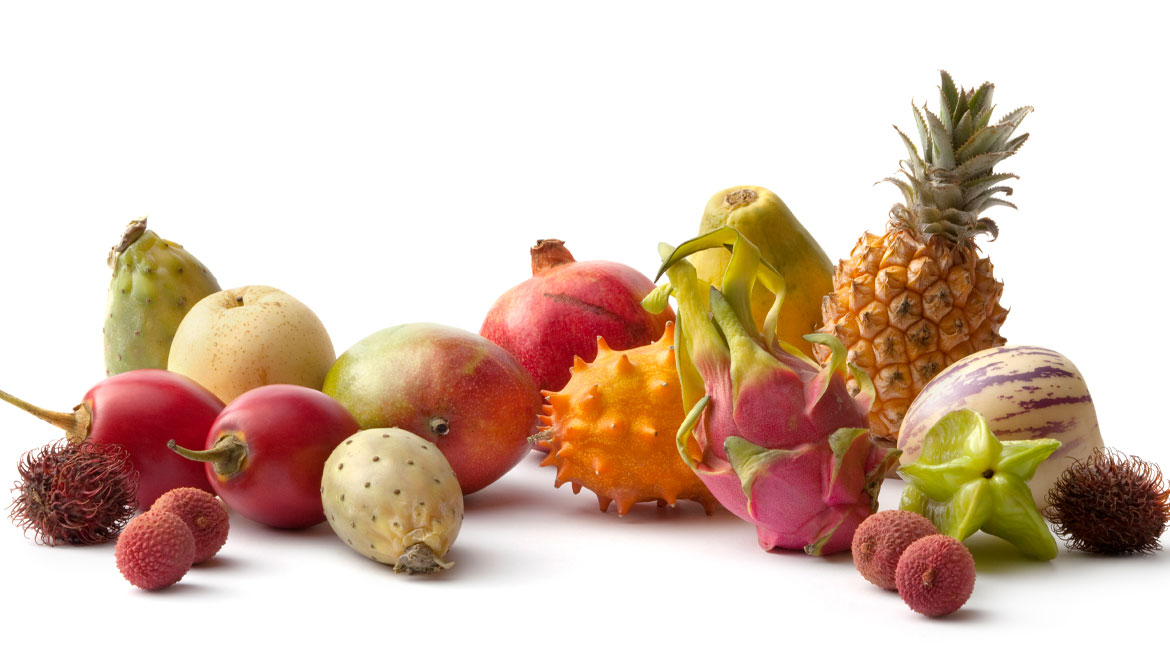

This picture displays a vibrant and diverse collection of **tropical and exotic fruits** arranged on a plain white background. The fruits are clustered together, showcasing a wide range of colors, shapes, and textures.

From left to right, I can identify:

*   On the far left, a red, hairy **rambutan** and two small, red, bumpy **lychees**.
*   Two red, oval-shaped **tamarillos** (or tree tomatoes) with green stems.
*   A green, bumpy **prickly pear** (or cactus fruit).
*   A round, pale yellow **Asian pear** (or Nashi pear).
*   A **mango** with green and reddish-orange skin.
*   A red **pomegranate** with its characteristic crown-like top.
*   A bright orange, spiky **kiwano** (or horned melon).
*   A striking pink and green **dragon fruit** (or pitaya).
*   An elongated, yellowish-green **papaya**.
*   A small, golden-orange **mini pineapple** with its spiky crown.
*   A pale yellow and purple striped, oval-shaped **pepino melon**.
*   A bright green, star-shaped **star fruit** (or 

In [81]:
#Use this to test out the API
gemini = GeminiClass()
# Gemini should give an in depth explanation
print(gemini.generate_content('Can you give me some information on how LLMs and VLMs work?',False))

#Gemini should give you an explanation that is only 2 sentences long
gemini.set_prompt("Please limit your response to 2 sentences.")
print(gemini.generate_content('Can you give me some information on how LLMs and VLMs work?',True))

#Gemini should describe the picture to you
image = data_path + '/API/image1.jpg'
image = Image.open(image)
display(image)
print(gemini.generate_from_image(image, 'What do you see in this picture?'))

# Problem 3: Vision
While Gemini is quite good at recognizing what is in an image, it struggles to give specific values for locations of objects. Google offers a Cloud Vision API that detects objects in an image and can return the pixel locations of the object. This is important for robotics applications if you want a target position based on an image.

In this you will fill out two functions: find_center and annotate_image. In annotate image, you will find all objects in the image, draw bounding boxes around them, and return the image. In find_center, you will return the center position of a specific object.

In [ ]:
class VisionObjectDetector:
    def __init__(self):
        """
        Initialize the Vision client once during object creation.
        """
        self.client = vision.ImageAnnotatorClient()

    def find_center(self, image_bytes, object_name):
        """
        Finds the center of an object (e.g., "pineapple") in the provided image bytes.

        :param image_bytes: The raw bytes of the image.
        :param object_name: The target object name to search for (case-insensitive).
        :return: Tuple (pixel_x, pixel_y) of the object's approximate center, or None if not found.
        """

        raise NotImplementedError
        # Step 1: Create the Vision Image object from bytes

        # Step 2: Send the image to the API for object localization

        # Step 3: Extract localized object annotations

        # Step 4: Search for the specified object. Hint: Objects returns all detected objects

        # Step 5: Once the object is found, determine the position from the bounding box. Hint: obj.bounding_poly returns the bounding box

        # Step 6: Find the center from the corners of the bounding box

        # Step 7: Return the center in pixel coordinates. Hint: The position of the bounding box is normalized so you will need to convert it back into the dimensions of the image

        return

    def annotate_image(self, image_bytes):
        """
        Detects all objects in the image and returns a PIL Image with
        bounding boxes and labels drawn for each detected object.

        :param image_bytes: The raw bytes of the image.
        :return: A PIL Image object annotated with bounding boxes and labels.
        """

        raise NotImplementedError
        # Step 1: Create the Vision Image object from bytes

        # Step 2: Send the image to the API for object localization

        # Step 3: Extract localized object annotations

        # Step 4: Open the image via PIL for drawing

        # Step 5: Iterate through all the objects and draw the bounding boxes on the image.
        # Hint: draw.polygon allows you to draw based on pixel coordinates

        #Step 6: Return the annotated image

        return



In [ ]:
#Use this to test your code. For each picture it should return coordinates of the object and an annotated image

#First file
image_content1 = data_path + "/API/image1.jpg"
with open(image_content1, "rb") as image_file:
    image_content1 = image_file.read()
detector = VisionObjectDetector()
center_coordinates = detector.find_center(image_content1, 'pineapple')
if center_coordinates:
    print("Center in pixel coordinates:", center_coordinates)
annotated_image = detector.annotate_image(image_content1)
display(annotated_image)

#Second file
image_content2 = data_path + "/API/image2.jpg"
with open(image_content2, "rb") as image_file:
    image_content2 = image_file.read()
detector = VisionObjectDetector()
center_coordinates = detector.find_center(image_content2, 'dog')
if center_coordinates:
    print("Center in pixel coordinates:", center_coordinates)
annotated_image = detector.annotate_image(image_content2)
display(annotated_image)

# Problem 4: Combined Example
Now you have worked with the three APIs individually, but where the APIs really shine is when they are used together. By utilizing their strengths together, you can build a pipeline.

For example in the group project, you might want to listen for what a person wants and then find where the object is in the scene. This requires recording the person's request, converting it to text, and then parsing the request to find what the object is. Once the obect is known, you would want to find its position in the scene to provide a target for the robot to navigate to.

In this, you will utilize the previous 3 APIs to develop a pipeline that can take an audio file and an image. The auido file will contain a statement of what the user wants i.e. "Bring me the banana", and the function should return the pixel coordinates of the banana in the image.


In [ ]:
class CombinedPipeline:
    def __init__(self):
        """
        Constructor for the CombinedPipeline class.
        Initializes instances of the SpeechTranscriber, VisionObjectDetector,
        and GeminiClass for processing audio, image, and text data.
        """
        self.tts = SpeechTranscriber()
        self.detector = VisionObjectDetector()
        # Initializes the GeminiClass with a prompt to extract the object from the voice transcript.
        self.gemini = GeminiClass(prompt="In the given voice transcript, identify what the object is that the user wants. Return only the object in lowercase and do not include any whitespaces, punctuation, or new lines. Here is the voice transcript: ")

        )

    def combined_pipeline(self, audio, image):
        """
        Processes audio and image inputs to determine the center coordinates of the object
        specified in the audio.

        Parameters:
        - audio: The audio input to be transcribed into text.
        - image: The image input in which the object should be detected.

        Returns:
        - center_coordinates: A tuple representing the (x, y) coordinates of the object's center,
          or None if the object is not found.
        """
        raise NotImplementedError

        # Hint: Even if Gemini responds with a single word, a new line character is always added at the end of the response.
        # Make sure to strip any symbols from the response before passing it to the vision detector.

        return


In [ ]:
#Use this to test out the API. The coordinates of the basketball should be returned

audio_content3 = data_path + "/API/recorded_audio3.wav"
with open(audio_content3, "rb") as audio_file:
    audio_content3 = audio_file.read()
image_content3 = data_path + "/API/image3.jpg"
with open(image_content3, "rb") as image_file:
    image_content3 = image_file.read()

pipeline = CombinedPipeline()
center_coordinates = pipeline.combined_pipeline(audio_content3, image_content3)
annotated_image = detector.annotate_image(image_content3)
display(annotated_image)
print("Center in pixel coordinates:", center_coordinates)

# Problem 5: Feature Detection

# Problem 5.1: Vision Color Detection

It is often helpful to use every feature at your disposal to extract information and context from a scene. Useful for the project is color detection of blocks in the scene. In this problem, you will generate masks for each color that will indicate which pixels are the particular color. This will require some hand-tuning to get sharp images of the specified colors.

You may find it particuarly helpful to filter the colors using the Hue, Saturation, Value space (HSV). Given a color specification in the set ['r','g','b','y'] (red,green,blue,yellow), your script must return an image with the blocks colors indicated (either show them as white and the rest of the pixels as black, or show the true color). You may use all opencv/python-base libraries at your disposal.


HSV space:

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Hsl-hsv_models.svg/1200px-Hsl-hsv_models.svg.png" width="500"/>
</div>

In [ ]:
def student_function_1(color_img, color_mask='r'):
    """Returns the black and white image with a color-mask for the specified color (white or the color where the color is, black everywhere else)

    Parameters
    ----------
    color_img : np.ndarray
        Raw input image of colored blocks on a table
    color_mask : string
        String indicating which color to draw the mask on; options 'r', 'g','b','y' (red, green, blue, yellow)

    Returns
    -------
    mask_img : np.ndarray
        Image with just the selected color shown (either with true color or white mask)
    """
    #Hint: one way would be to define threshold in HSV, leverage that to make a mask?

    raise NotImplementedError
    #Step 1: Convert to HSV space; OpenCV uses - H: 0-179, S: 0-255, V: 0-255

    #Step 2: prep the mask

    #Step 3: Apply the mask; black region in the mask is 0, so when multiplied with original image removes all non-selected color

    return mask_img


### Code Verification
Please run the following blocks:

In [ ]:
c1_img = cv2.cvtColor(cv2.imread(data_path + "/color/c1.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)#default cv2 read-in is bgr (blue, green, red) but cameras often use RGB convention, so we simply reorder to get it right here.
c1_red_img = student_function_1(c1_img,color_mask='r')
c1_green_img = student_function_1(c1_img,color_mask='g')
c1_blue_img = student_function_1(c1_img,color_mask='b')
c1_yellow_img = student_function_1(c1_img,color_mask='y')
plt.figure()
plt.subplot(221)
plt.imshow(c1_red_img)
plt.subplot(222)
plt.imshow(c1_green_img)
plt.subplot(223)
plt.imshow(c1_blue_img)
plt.subplot(224)
plt.imshow(c1_yellow_img)
plt.show()

In [ ]:
c2_img = cv2.cvtColor(cv2.imread(data_path + "/color/c2.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
c2_red_img = student_function_1(c2_img,color_mask='r')
c2_green_img = student_function_1(c2_img,color_mask='g')
c2_blue_img = student_function_1(c2_img,color_mask='b')
c2_yellow_img = student_function_1(c2_img,color_mask='y')
plt.figure()
plt.subplot(221)
plt.imshow(c2_red_img)
plt.subplot(222)
plt.imshow(c2_green_img)
plt.subplot(223)
plt.imshow(c2_blue_img)
plt.subplot(224)
plt.imshow(c2_yellow_img)
plt.show()

In [ ]:
c3_img = cv2.cvtColor(cv2.imread(data_path + "/color/c3.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
c3_red_img = student_function_1(c3_img,color_mask='r')
c3_green_img = student_function_1(c3_img,color_mask='g')
c3_blue_img = student_function_1(c3_img,color_mask='b')
c3_yellow_img = student_function_1(c3_img,color_mask='y')
plt.figure()
plt.subplot(221)
plt.imshow(c3_red_img)
plt.subplot(222)
plt.imshow(c3_green_img)
plt.subplot(223)
plt.imshow(c3_blue_img)
plt.subplot(224)
plt.imshow(c3_yellow_img)
plt.show()

Often color is not the only nor best feature to detect in a scene. Alternatively edges and corners serve as better features to detect. In the following functions you will leverage opencv functions to find edges and corners (good features to track between frames).

## Problem 5.2: Edge Detection
For this problem, you will want to leverage the *Canny Edge detector* to track edges in the frame (arguments will be directly useful for its functionality, see documentation).

In [ ]:
def student_function_2(img_input, threshold1=100, threshold2=200):
    """ this script takes in an image and returns the edges using the Canny Edge detector algorithm

    Parameters
    ----------
    img_input : np.ndarray
        Raw input image of environment
    threshold1 : float
        Float value for lower threshold of canny hysteresis procedure
    threshold2 : float
        Float value for upper threshold of canny hysteresis procedure

    Returns
    -------
    Canny_edges : np.ndarray
        Image with canny edges
    """
    #Hint: Documentation exists for the cv2 canny function...
    raise NotImplementedError

    return edge_img


### 5.2 Evaluation
Please run the following block for evaluation

In [ ]:
#load image for edge detection
feature_img = cv2.cvtColor(cv2.imread(data_path + "/feature_pose/pose1.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)#default cv2 read-in is bgr (blue, green, red) but cameras often use RGB convention, so we simply reorder to get it right here.
#send to Student script for edge detection
edge_img = student_function_2(feature_img,threshold1=10, threshold2=60)
#display img
plt.figure()
plt.subplot(211)
plt.imshow(feature_img)
plt.subplot(212)
plt.imshow(edge_img)
plt.show()

## Problem 5.3: Tracking 'Good Features'
Lines can be useful, but often to track an object or set of objects, its important to track corner features. Opencv makes it easy to leverage algorithms like *Good Features to Track* which rely on algorithms like *Shi-Tomasi Corner Detector*. In this function, you will leverage the *Good Features to Track* algorithm to track corners in the scene (useful towards tracking rigid bodies or fiducials (e.g. apriltags)).

In [ ]:
def student_function_3(img_input, maxCorners=100, qualityLevel=200,min_distance=10):
    """ This function takes in an image and detects corners

    Parameters
    ----------
    img_input : np.ndarray
        Raw input image of environment
    maxCorners : float
        Maximum number of corners to return. If there are more corners than are
        found, the strongest of them is returned.
    qualityLevel : float
        Parameter characterizing the minimal accepted quality of image corners.
        The parameter value is multiplied by the best corner quality measure,
        which is the minimal eigenvalue (see cornerMinEigenVal ) or the Harris
        function response (see cornerHarris ). The corners with the quality
        measure less than the product are rejected. For example, if the best
        corner has the quality measure = 1500, and the qualityLevel=0.01 ,
        then all the corners with the quality measure less than 15 are rejected
    min_distance : int
        Minimum possible Euclidean distance between the returned corners

    Returns
    -------
    Canny_edges : np.ndarray
        Gray scale image with canny edges
    """
    #Hint: Documentation exists for the cv2 Shi-Tomasi Corner Detector & Good Features to Track...
    #Hint: copying an image: newImage = myImage.copy()
    raise NotImplementedError

    #Step 1: Gray scale the original image

    #Step 2: Extract corners from the image

    #Step 3: redraw them (as circles) on a copy of the image to return

    return img_copy

## 5.3 Evaluation
Please run the following block for evaluation

In [ ]:
#load image for feature detection
raw_img = cv2.cvtColor(cv2.imread(data_path+"/feature_pose/pose1.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)#default cv2 read-in is bgr (blue, green, red) but cameras often use RGB convention, so we simply reorder to get it right here.
#send to Student script for feature detection
good_features_img = student_function_3(raw_img, maxCorners=500, qualityLevel=0.01,min_distance=10)
#display img
plt.figure()
plt.subplot(211)
plt.imshow(raw_img)
plt.subplot(212)
plt.imshow(good_features_img)
plt.show()

## Problem 6: Perspective-n-Point (PnP)

Given an ability to track good features in our scene, if we have some prior knoweldge about rigid bodies in the scene then we can leverage that to track the relative pose between the camera and the tracked object. In the following script, you will perform pose tracking of an [AprilTag](https://people.csail.mit.edu/kaess/apriltags/) *however* **you must either use OpenCV to perform perspective-n-point or generate this algorithm yourself (you may not use Apriltag base code to solve this problem)**.

Points on the tags are indexed as follows:

<div>
<img src="https://berndpfrommer.github.io/tagslam_web/media/tag_corners.png" width="500"/>
</div>

We will denote the points on the tag (0:3) (in the csv, the index name goes from (1:4)) in the frame of the tag (center reference frame) as $(w_{i,x},w_{i,y})$ and in the image plane, we will use pixels $(u_{i,x},u_{i,y})$. The goal is to determine the pose of the tags reference frame relative to the camera's reference frame.

The calibration matrix of the camera is $$K = \begin{bmatrix}
915.1482543945312 & 0.0 & 633.98828125 \\
0.0 & 915.0738525390625 & 363.17529296875 \\
 0.0 & 0.0 & 1.0
\end{bmatrix}  = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
 0 & 0 & 1.0
\end{bmatrix}$$

The camera frames follows the convention shown here for either of the fish-eye lenses (**Camera used for this data collection did not have noticable distortion**):
<div>
<img src="https://user-images.githubusercontent.com/6543766/64158631-20303a00-ce39-11e9-9c63-fe0baa8135ff.png" width="500"/>
</div>




### Camera Model:
$$\lambda \begin{bmatrix}u \\ v \\ 1 \end{bmatrix}_{3\times 1} = \underbrace{ \underbrace{\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
 0 & 0 & 1.0
\end{bmatrix}}_{K_{3\times 3}}
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
\end{bmatrix}}_{P_{3\times 4}} \underbrace{\begin{bmatrix} w_X \\ w_Y \\ w_Z \\ 1 \end{bmatrix}}_{\tilde{X}_{4\times 1}}$$
By leveraging the crossproduct relation $[u]_{[\times]} v = u \times v$ (vector cross product with itself is zero) we have the relation:
$$\begin{bmatrix}u \\ v \\ 1 \end{bmatrix}_{[\times]} P \tilde{X} = 0_{3 \times 1} $$

So by reorganizing with the rows of $P$ being represented by
$$P = \begin{bmatrix} P_{1,1 \times 4} \\ P_{2,1 \times 4} \\ P_{3,1\times 4} \end{bmatrix}$$ then we have the relation:

$$\underbrace{\begin{bmatrix}
0_{1\times 4} & -\tilde{X}^T & v \tilde{X}^T\\
\tilde{X}^T & 0_{1\times 4} & -u \tilde{X}^T \\
- v \tilde{X}^T & u \tilde{X}^T & 0_{1\times 4}
\end{bmatrix}_{3\times 12}}_{A_i} \begin{bmatrix}P_1^T \\ P_2^T \\ P_3^T \end{bmatrix} = 0_{3\times 1}$$

for the i'th point, then for 4 points we have:
$$\underbrace{\begin{bmatrix}A_1 \\A_2 \\A_3 \\A_4  \end{bmatrix}_{12 \times 12}}_{\tilde{A}} \begin{bmatrix}P_1^T \\ P_2^T \\ P_3^T \end{bmatrix}_{12 \times 1} = 0_{12\times 1}$$

## Steps:

There are two ways to solve this problem, the easier (and full points) is to use the opencv Perspective-n-Point function `cv2.solvePnP()` [documentation](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga549c2075fac14829ff4a58bc931c033d). Alternatively, for your own development you may choose to reimplement the algorithm yourself (no extra points, just self-betterment and kudos!), if you decide to do that, a general step-by-step suggested algorithm is presented below. **Solutions will be provided for the opencv function only**

### If you decide to implement the full algorithm yourself (as opposed to opencv PnP function), some helpful steps include:
#### Step 1: Generate $\tilde{A}$ Matrix
Recall $\underbrace{\begin{bmatrix}
0_{1\times 4} & -\tilde{X}^T & v \tilde{X}^T\\
\tilde{X}^T & 0_{1\times 4} & -u \tilde{X}^T \\
- v \tilde{X}^T & u \tilde{X}^T & 0_{1\times 4}
\end{bmatrix}_{3\times 12}}_{A_i}$

#### Step 2: Use SVD on $\tilde{A}$ to determine possible solutions of P
Using the Right eigenvectors with Singular Value Decomposition (SVD), which are feasible solutions? (which would place the camera position in front of the camera (positive $p_z$)? Note, you may have to solve the other steps below to obtain $p_z$ to make sure its feasible.
[Hint](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html):
`np.linalg.svd`
**SVD**

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/440px-Singular_value_decomposition_visualisation.svg.png" width="200"/>
</div>

#### Step 3: Given a potential solution of P, extract the rotation and translation
Recall $P = K[R,t]$, so given $K$ you can find $[R,t]$. But remember, R is an orthogonal, positive definite matrix $r_1 \times r_2 = r_3$ ($r_i$ is column of $R$) and $det(R) = +1$.

#### Step 4: convert Rotation matrix to quaternion then return position and quaternion is the function request
Return $\begin{bmatrix}p_x, p_y, p_z, q_x, q_y, q_z, q_w \end{bmatrix}$. Check your first two answers against those given in the csv file, the rest are zeros you will have to populate.
Hint: [scipy.spatial.transform.Rotation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html)

## Your Code Here:

In [ ]:
def quat_from_axis_angle(v):
    """
    Helper function if you have an axis-angle vector and wish to find the quaternion
    Params
    ---
    v: np.ndarray (3x1)
        axis-angle representation of rotation
    Returns
    ---
    q: list
        list of quaternion elements
    """
    angle = np.linalg.norm(np.matrix(v))
    vect = v/angle
    qw = np.cos(angle/2)
    qx = vect.item(0)*np.sin(angle/2)
    qy = vect.item(1)*np.sin(angle/2)
    qz = vect.item(2)*np.sin(angle/2)
    return [qx,qy,qz,qw]

def student_function_4(world_xyz_pts,pixel_uv_pts,K_calib,dist=np.zeros((4,1))):
    """
    This function takes in the world points, camera points, calibration matrix and returns the pose of the tag relative to the
    camera frame
    Parameters
    ----------
    pixel_uv_pts : np.ndarray
        List of input pixel points of each corner of the tag [[p1x,p1y],[p2x,p2y],[p3x,p3y],[p4x,p4y]]
        (using the notation from the demonstration figure, index from 0:3 yeilds [[p0x,p0y],[p1x,p1y],[p2x,p2y],[p3x,p3y]])
    world_xyz_pts : np.ndarray
        The tag has a constant size (and shape - flat), hence this array is constant: [['w1x', 'w1y', 'w1z'], ['w2x', 'w2y', 'w2z'], ['w3x', 'w3y', 'w3z'], ['w4x', 'w4y', 'w4z']]

    K_calib : np.ndarray (3x3)
        Parameter characterizing the minimal accepted quality of image corners.
        The parameter value is multiplied by the best corner quality measure,
        which is the minimal eigenvalue (see cornerMinEigenVal ) or the Harris
        function response (see cornerHarris ). The corners with the quality
        measure less than the product are rejected. For example, if the best
        corner has the quality measure = 1500, and the qualityLevel=0.01 ,
        then all the corners with the quality measure less than 15 are rejected
    dist : np.ndarray (4x1)
        Distortion params, if distortion is not significant these can be left as zeros (applicable for intel realsense camera used for this dataset)

    Returns
    ----------
    pose : np.ndarray
        pose of the tag in camera frame
    """
    raise NotImplementedError

    return pose

## Evaluation Prob 6
Points associated with the images are saved in a CSV file, the ordering of the points are shown below. For the first two points, the poses of the tag in the camera frame are provided, your script must correctly fill in the rest.
**Run the block below for evaluation, then upload the resulting csv with your notebook to Canvas**
$$\begin{bmatrix} ID & u_{c,x}& u_{c,y} & u_{1,x}& u_{1,y} & u_{2,x} & u_{2,y} & u_{3,x} &  u_{3,y} & u_{4,x} & u_{4,y} & w_{1,x} & w_{1,y} & w_{1,z} & w_{2,x} & w_{2,y} & w_{2,z} & w_{3,x} & w_{3,y} & w_{3,z} & w_{4,x} & w_{4,y} & w_{4,z} & p_x & p_y & p_z & q_x & q_y & q_z & q_w \end{bmatrix}$$

In [ ]:
import csv
#key is to put the data folder at the same level as the notebook when running locally
with open(data_path + '/feature_pose/feature_keyframes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    feature_list = []
    for row in spamreader:
        feature_list.append(row[:])

#convert csv of strings to numbers for appropriate rows/cols:
for idx in range(1,len(feature_list)):
    for jdx in range(1,len(feature_list[idx])):
        feature_list[idx][jdx] = float(feature_list[idx][jdx])

def extract_information(pr):
    pixel_uv_pts = np.array([[pr[3],pr[4]],
                              [pr[5],pr[6]],
                              [pr[7],pr[8]],
                              [pr[9],pr[10]]])
    world_xyz_pts = np.array([[pr[11],pr[12],pr[13]],
                             [pr[14],pr[15],pr[16]],
                             [pr[17],pr[18],pr[19]],
                             [pr[20],pr[21],pr[22]]])
    return pixel_uv_pts,world_xyz_pts

#make the calibration matrix K (comes from intelrealsense for given camera (provided in camera_info topic))
calib_matrix = np.array([[915.1482543945312,0.0 , 633.98828125],
                         [0.0 , 915.0738525390625 , 363.17529296875],
                         [0.0 , 0.0 , 1.0]])

predicted_pose_list = []
for idx in range(7):
    pose_row = feature_list[idx+1]
    pixel_uv_pts,world_xyz_pts = extract_information(pose_row)
    pose = student_function_4(world_xyz_pts,pixel_uv_pts,calib_matrix)
    predicted_pose_list.append(pose)

student_feature_list = np.copy(feature_list) #initalize with previous list
for idx in range(7):
    for jdx in range(7):
        student_feature_list[idx+1][jdx+23] = predicted_pose_list[idx][jdx]

#now save this to a new csv file to be saved for grading
with open(data_path+'feature_keyframes_student.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idx in range(8):
        spamwriter.writerow(student_feature_list[idx].tolist())
